# Generative Adversarial Networks

## Copyright notice

Parts of this code are adapted from Erik Linder-Norén's [GAN implementation repository](https://github.com/eriklindernoren/Keras-GAN/blob/master/gan/gan_rgb.py), Copyright (c) 2017 Erik Linder-Norén, [MIT License](https://github.com/eriklindernoren/Keras-GAN/blob/master/LICENSE). This version (c) 2018 Fabian Offert, [MIT License](LICENSE).

## Gerhard Richter, Selbstportrait (1996)
<br>![](https://www.gerhard-richter.com/datadir/images_new/xxlarge/16760.jpg)<br>

## Imports

Link to CelebA dataset: https://www.floydhub.com/mirantha/datasets/celeba

In [1]:
import warnings
warnings.filterwarnings('ignore')

from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.preprocessing.image import load_img, img_to_array

import numpy as np
from scipy.misc import imread, imsave, imresize
import PIL.Image

import os
from glob import glob
from io import BytesIO
import uuid
from subprocess import call

from IPython.display import clear_output, Image, display

Using TensorFlow backend.


In [2]:
# Normalize each color sepearately (Photoshop auto tone)
def autotone(img):
    img[:,:,0] = np.interp(img[:,:,0], [np.amin(img[:,:,0]), np.amax(img[:,:,0])], [0, 255])
    img[:,:,1] = np.interp(img[:,:,1], [np.amin(img[:,:,1]), np.amax(img[:,:,1])], [0, 255])
    img[:,:,2] = np.interp(img[:,:,2], [np.amin(img[:,:,2]), np.amax(img[:,:,2])], [0, 255])
    return img

def deprocess_image(x):
    x = x.reshape((x.shape[1], x.shape[2], 3)) # "Remove" extra dimension, channels last
    x = (1/2.5) * x + 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8') # Clip to visible range
    x = autotone(x)
    return x

# Simple save function based on scipy
def save_image(img, fname):
    pil_img = deprocess_image(np.copy(img))
    imsave(fname, pil_img)
    
def save_image_numbered(img, nr, folder):
    if not os.path.exists(folder): os.makedirs(folder)
    f = '{0:05d}'.format(nr)
    p = folder + '/' + f + '.jpg'
    save_image(img, p)
    
def montage_images(folder, w, h):
    print('Montaging...')
    geometry = '-geometry "' + str(w) + 'x' + str(h) + '+2+2>" '
    label = '-label "%t" '
    output = folder + '/montage.jpg'
    infiles = folder + '/*.jpg '
    montage = 'montage  ' + label + infiles + geometry + output
    call(montage, shell=True)
    print('...done.')
    
def show_image(img, fmt='jpeg'):
    img = deprocess_image(np.copy(img))
    f = BytesIO()
    PIL.Image.fromarray(img).save(f, fmt)
    display(Image(data=f.getvalue()))
    
def get_image(file):
    # Returns original size
    img = load_img(file)
    img = img_to_array(img) # Reverses dimensions!
    return img

def get_dataset(files):
    data_batch = np.array([get_image(file) for file in files])
    return data_batch

def save_weights(generator, discriminator, epoch, folder):
    if not os.path.exists(folder): os.makedirs(folder)
    generator.save_weights(folder + '/generator-' + str(epoch) + '.hdf5')
    discriminator.save_weights(folder + '/discriminator-' + str(epoch) + '.hdf5')

## Hyperparameters

In [3]:
epochs = 50000
w = 178 # Original dataset size
h = 218 # Original dataset size
latent_dim = 100
lr = 0.0002
beta_1 = 0.5
info_interval = 200
save_weights_interval = 10000
batch_size = 32
dataset_size = 5000 # How many images to use from CelebA
load_generator = ''
load_discriminator = ''
start_epoch = 0

img_shape = (h, w, 3) # Reversed
noise_shape = (latent_dim,)

## Architecture

<br>![](6-gans/architecture.png)<br>

In [4]:
def build_generator():

    model = Sequential()
    model.add(Dense(256, input_shape=noise_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))
    model.summary()

    noise = Input(shape=noise_shape)
    img = model(noise)

    return Model(noise, img)

In [5]:
def build_discriminator():

    model = Sequential()
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    img = Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)

In [6]:
optimizer = Adam(0.0002, 0.5)

# Build and compile the discriminator
discriminator = build_discriminator()
if load_discriminator != '': discriminator.load_weights(load_discriminator)
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Build the generator
generator = build_generator()
if load_generator != '': generator.load_weights(load_generator)

# The generator takes noise as input and generates an image
z = Input(shape=(latent_dim,))
img = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes an image as input and determines provenance
p = discriminator(img)

# Combines model
combined = Model(z, p)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

X_train = get_dataset(glob(os.path.join('6-gans/CelebA/', '*.jpg'))[:dataset_size])
# Rescale -1 to 1
X_train = (X_train.astype(np.float32) - 127.5) / 127.5

# Adversarial ground truth
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 116412)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               59603456  
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 59,735,041
Trainable params: 59,735,041
Non-trainable params: 0
________________________________________________________________

## Training

0 [D loss: 0.668881, acc.: 42.19%] [G loss: 0.685088]


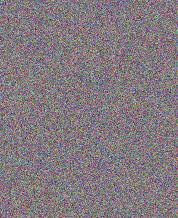

Saving weights...
...done.
200 [D loss: 2.026252, acc.: 57.81%] [G loss: 4.806546]


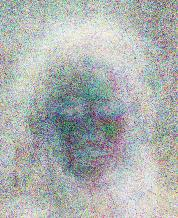

400 [D loss: 1.447389, acc.: 62.50%] [G loss: 7.170439]


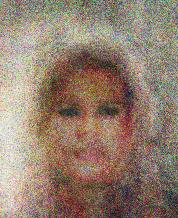

600 [D loss: 1.349176, acc.: 59.38%] [G loss: 5.392425]


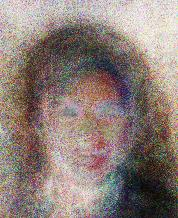

800 [D loss: 1.652683, acc.: 68.75%] [G loss: 7.114262]


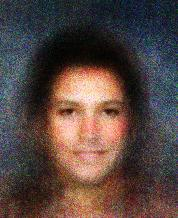

1000 [D loss: 0.853072, acc.: 60.94%] [G loss: 5.137247]


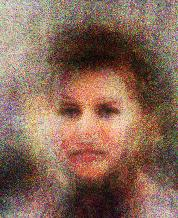

1200 [D loss: 0.545945, acc.: 78.12%] [G loss: 4.230402]


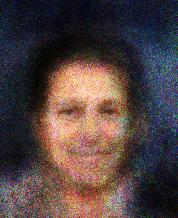

1400 [D loss: 0.989166, acc.: 48.44%] [G loss: 5.995792]


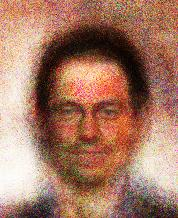

1600 [D loss: 0.562958, acc.: 76.56%] [G loss: 6.470964]


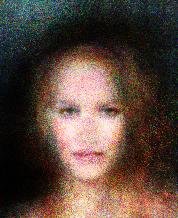

1800 [D loss: 1.034728, acc.: 68.75%] [G loss: 5.123449]


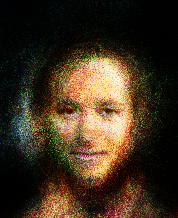

2000 [D loss: 0.742392, acc.: 73.44%] [G loss: 7.270728]


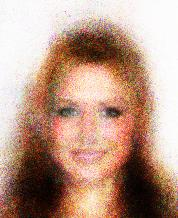

2200 [D loss: 0.695782, acc.: 60.94%] [G loss: 4.411518]


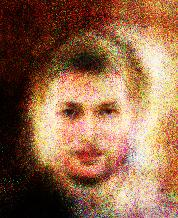

2400 [D loss: 0.994154, acc.: 60.94%] [G loss: 4.034273]


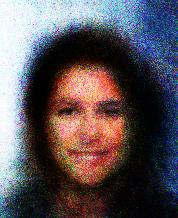

2600 [D loss: 1.064702, acc.: 59.38%] [G loss: 6.049926]


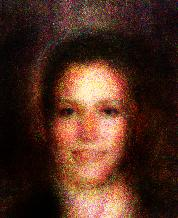

2800 [D loss: 0.676435, acc.: 70.31%] [G loss: 5.875286]


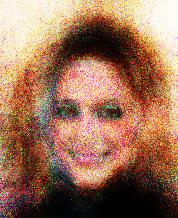

3000 [D loss: 0.592844, acc.: 78.12%] [G loss: 5.351878]


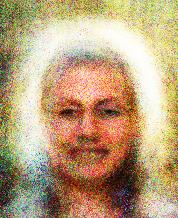

3200 [D loss: 0.267242, acc.: 89.06%] [G loss: 5.960417]


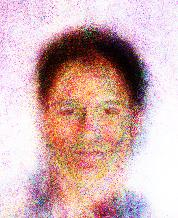

3400 [D loss: 0.520991, acc.: 84.38%] [G loss: 5.223590]


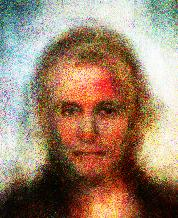

3600 [D loss: 0.537373, acc.: 84.38%] [G loss: 4.498024]


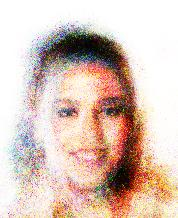

3800 [D loss: 0.559565, acc.: 79.69%] [G loss: 6.877554]


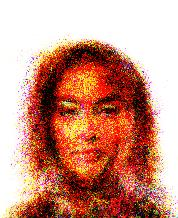

4000 [D loss: 0.374125, acc.: 79.69%] [G loss: 5.197134]


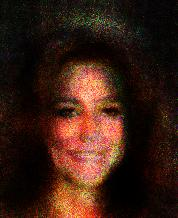

4200 [D loss: 0.188558, acc.: 92.19%] [G loss: 5.408432]


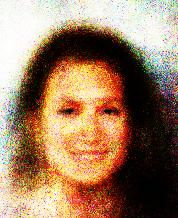

4400 [D loss: 0.583984, acc.: 71.88%] [G loss: 8.472270]


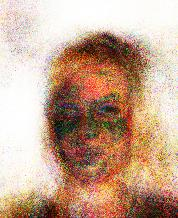

4600 [D loss: 0.367815, acc.: 81.25%] [G loss: 5.647860]


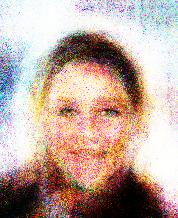

4800 [D loss: 0.870393, acc.: 64.06%] [G loss: 7.209549]


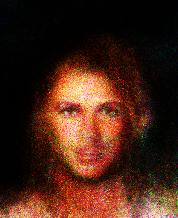

5000 [D loss: 0.424415, acc.: 79.69%] [G loss: 4.602107]


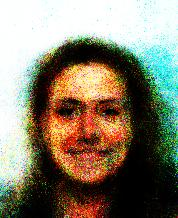

5200 [D loss: 0.777917, acc.: 71.88%] [G loss: 5.372214]


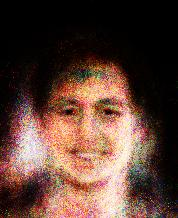

5400 [D loss: 1.125739, acc.: 73.44%] [G loss: 7.518938]


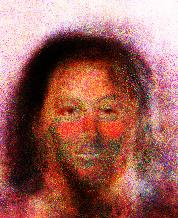

5600 [D loss: 0.356226, acc.: 79.69%] [G loss: 8.206739]


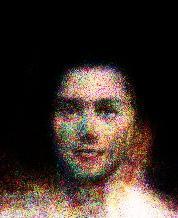

5800 [D loss: 0.518999, acc.: 75.00%] [G loss: 6.832051]


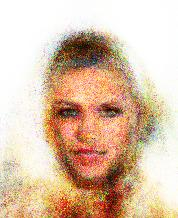

6000 [D loss: 0.449042, acc.: 79.69%] [G loss: 8.189212]


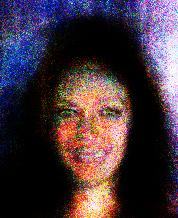

6200 [D loss: 0.609030, acc.: 75.00%] [G loss: 4.476918]


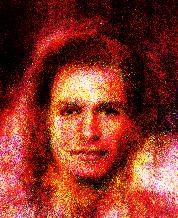

6400 [D loss: 0.510865, acc.: 75.00%] [G loss: 6.217286]


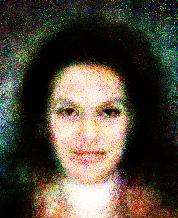

6600 [D loss: 0.628501, acc.: 73.44%] [G loss: 6.223244]


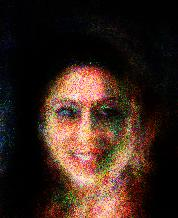

6800 [D loss: 0.238828, acc.: 87.50%] [G loss: 6.635914]


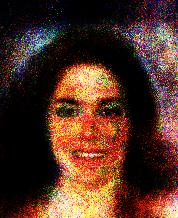

7000 [D loss: 0.468758, acc.: 84.38%] [G loss: 6.236393]


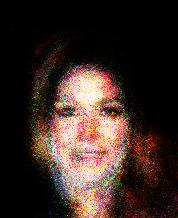

7200 [D loss: 0.453066, acc.: 92.19%] [G loss: 6.808018]


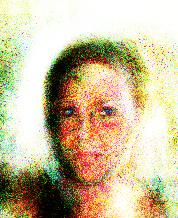

7400 [D loss: 0.524529, acc.: 78.12%] [G loss: 5.490027]


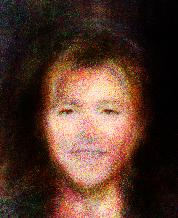

7600 [D loss: 0.591077, acc.: 79.69%] [G loss: 6.285036]


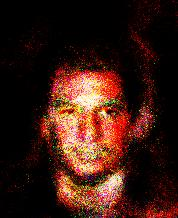

7800 [D loss: 1.008814, acc.: 64.06%] [G loss: 10.280577]


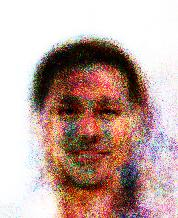

8000 [D loss: 0.584305, acc.: 76.56%] [G loss: 4.316914]


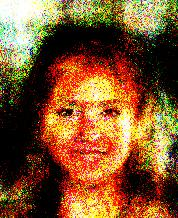

8200 [D loss: 0.495946, acc.: 82.81%] [G loss: 6.882769]


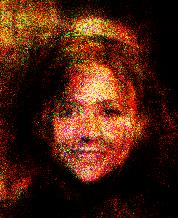

8400 [D loss: 0.539810, acc.: 87.50%] [G loss: 6.854551]


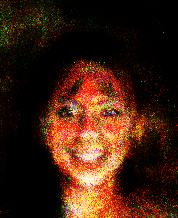

8600 [D loss: 0.991359, acc.: 65.62%] [G loss: 6.397040]


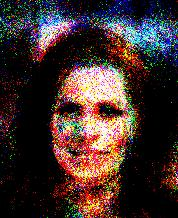

8800 [D loss: 0.141768, acc.: 95.31%] [G loss: 7.301433]


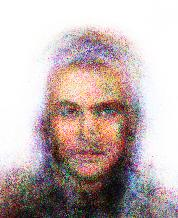

9000 [D loss: 0.205219, acc.: 90.62%] [G loss: 8.629203]


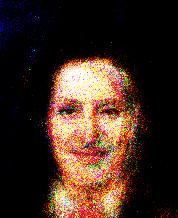

9200 [D loss: 0.144763, acc.: 93.75%] [G loss: 6.344720]


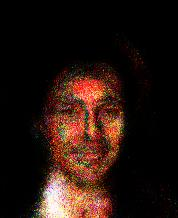

9400 [D loss: 0.319746, acc.: 85.94%] [G loss: 6.085725]


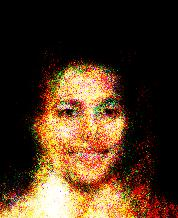

9600 [D loss: 0.418562, acc.: 84.38%] [G loss: 6.459506]


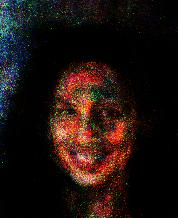

9800 [D loss: 0.535240, acc.: 84.38%] [G loss: 6.441764]


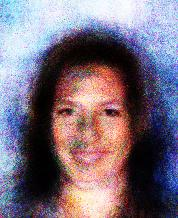

10000 [D loss: 0.243942, acc.: 92.19%] [G loss: 6.055388]


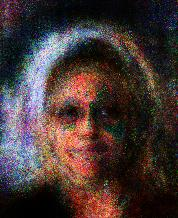

Saving weights...
...done.
10200 [D loss: 0.689414, acc.: 79.69%] [G loss: 7.729980]


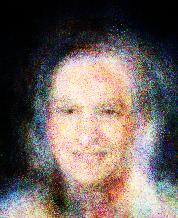

10400 [D loss: 0.087534, acc.: 95.31%] [G loss: 5.361578]


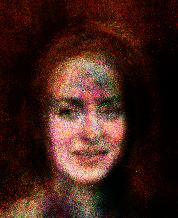

10600 [D loss: 0.335365, acc.: 79.69%] [G loss: 7.566812]


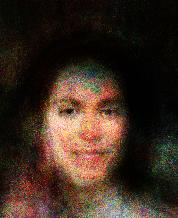

10800 [D loss: 0.478157, acc.: 87.50%] [G loss: 5.884378]


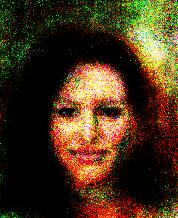

11000 [D loss: 0.534748, acc.: 78.12%] [G loss: 7.377966]


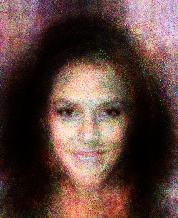

12000 [D loss: 1.029785, acc.: 68.75%] [G loss: 8.314621]


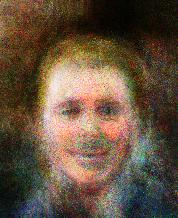

12200 [D loss: 0.403838, acc.: 89.06%] [G loss: 6.996245]


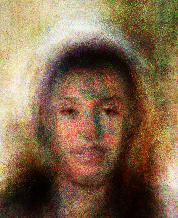

12400 [D loss: 0.214573, acc.: 90.62%] [G loss: 5.204544]


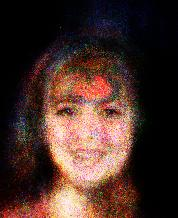

12600 [D loss: 0.352437, acc.: 87.50%] [G loss: 6.360465]


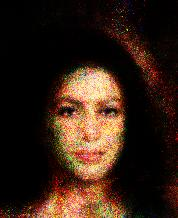

12800 [D loss: 0.824659, acc.: 79.69%] [G loss: 7.847617]


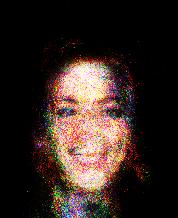

13000 [D loss: 0.217614, acc.: 90.62%] [G loss: 8.467630]


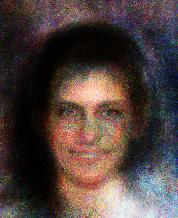

13200 [D loss: 0.500489, acc.: 73.44%] [G loss: 7.853226]


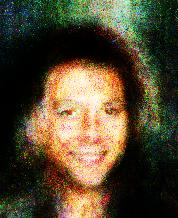

13400 [D loss: 0.221243, acc.: 95.31%] [G loss: 5.753981]


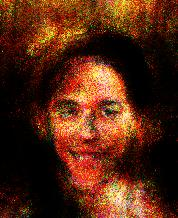

13600 [D loss: 0.171541, acc.: 95.31%] [G loss: 7.965980]


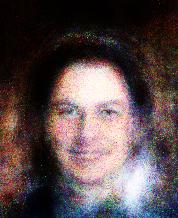

13800 [D loss: 0.094034, acc.: 93.75%] [G loss: 6.800675]


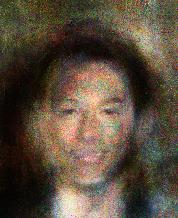

14000 [D loss: 0.234432, acc.: 92.19%] [G loss: 8.326736]


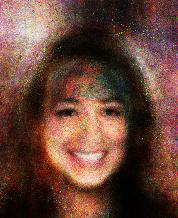

14200 [D loss: 0.260506, acc.: 89.06%] [G loss: 4.099187]


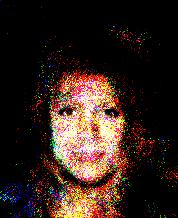

14400 [D loss: 0.749510, acc.: 79.69%] [G loss: 8.506084]


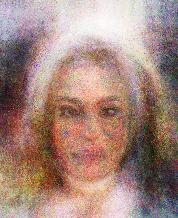

14600 [D loss: 0.515367, acc.: 84.38%] [G loss: 5.467480]


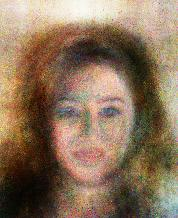

14800 [D loss: 0.171557, acc.: 95.31%] [G loss: 6.909121]


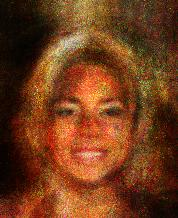

15000 [D loss: 0.103397, acc.: 96.88%] [G loss: 4.585401]


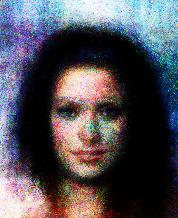

15200 [D loss: 0.319885, acc.: 87.50%] [G loss: 7.994702]


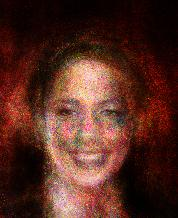

15400 [D loss: 0.320963, acc.: 87.50%] [G loss: 8.230272]


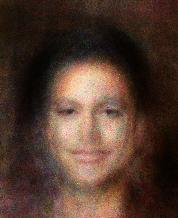

15600 [D loss: 0.472456, acc.: 81.25%] [G loss: 7.944468]


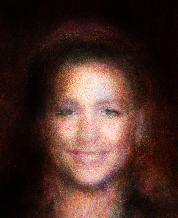

15800 [D loss: 0.376831, acc.: 82.81%] [G loss: 5.678778]


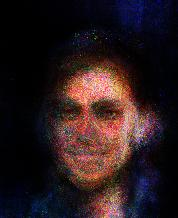

16000 [D loss: 0.450425, acc.: 85.94%] [G loss: 6.084052]


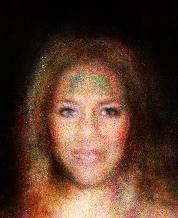

16200 [D loss: 0.868434, acc.: 70.31%] [G loss: 3.504707]


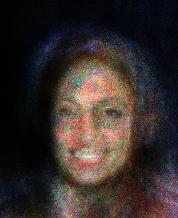

16400 [D loss: 2.841365, acc.: 42.19%] [G loss: 8.228693]


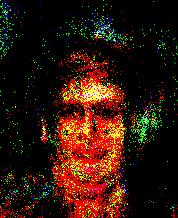

16600 [D loss: 0.321142, acc.: 89.06%] [G loss: 6.150160]


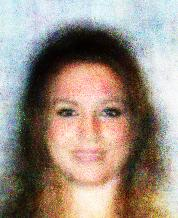

16800 [D loss: 0.169695, acc.: 93.75%] [G loss: 10.802762]


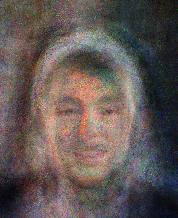

17000 [D loss: 0.650538, acc.: 76.56%] [G loss: 6.786719]


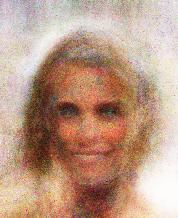

17200 [D loss: 0.270003, acc.: 87.50%] [G loss: 7.073086]


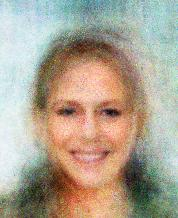

17400 [D loss: 0.240576, acc.: 93.75%] [G loss: 5.593815]


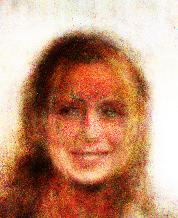

17600 [D loss: 0.236641, acc.: 90.62%] [G loss: 4.121459]


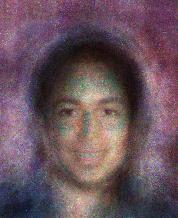

17800 [D loss: 0.160429, acc.: 93.75%] [G loss: 6.435856]


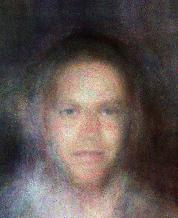

18000 [D loss: 0.143755, acc.: 93.75%] [G loss: 6.849463]


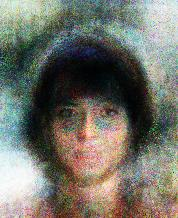

18200 [D loss: 0.141397, acc.: 93.75%] [G loss: 6.832722]


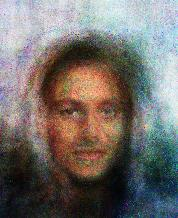

18400 [D loss: 0.180168, acc.: 89.06%] [G loss: 6.141575]


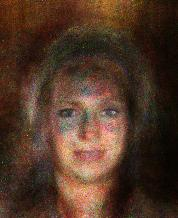

18600 [D loss: 0.413300, acc.: 82.81%] [G loss: 6.358299]


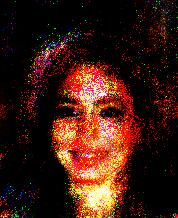

18800 [D loss: 0.309196, acc.: 90.62%] [G loss: 7.640091]


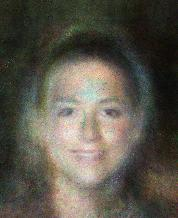

19000 [D loss: 0.142251, acc.: 96.88%] [G loss: 6.474612]


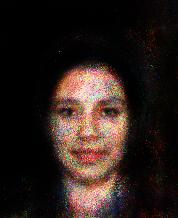

19200 [D loss: 0.294122, acc.: 90.62%] [G loss: 5.268314]


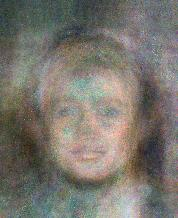

19400 [D loss: 0.516521, acc.: 85.94%] [G loss: 6.464154]


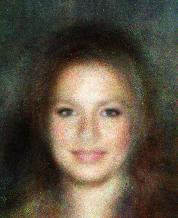

19600 [D loss: 0.380976, acc.: 85.94%] [G loss: 6.244437]


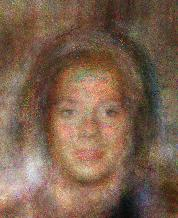

19800 [D loss: 0.176934, acc.: 93.75%] [G loss: 6.498293]


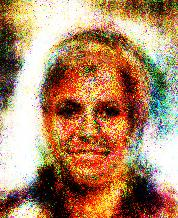

20000 [D loss: 0.177617, acc.: 90.62%] [G loss: 6.031185]


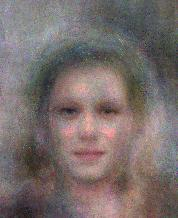

Saving weights...
...done.
20200 [D loss: 0.077741, acc.: 98.44%] [G loss: 5.782624]


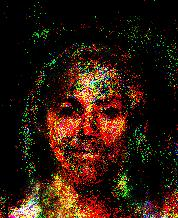

20400 [D loss: 0.050761, acc.: 96.88%] [G loss: 10.383556]


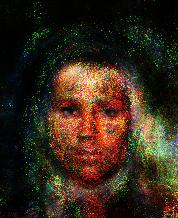

20600 [D loss: 0.121767, acc.: 95.31%] [G loss: 6.345784]


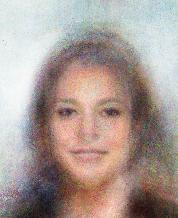

20800 [D loss: 0.239874, acc.: 90.62%] [G loss: 6.577921]


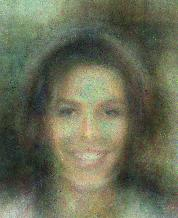

21000 [D loss: 0.585756, acc.: 76.56%] [G loss: 4.373606]


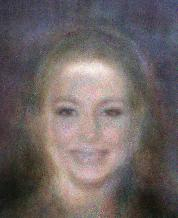

21200 [D loss: 0.229107, acc.: 93.75%] [G loss: 6.143044]


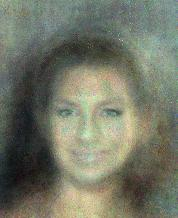

21400 [D loss: 0.155155, acc.: 93.75%] [G loss: 6.801891]


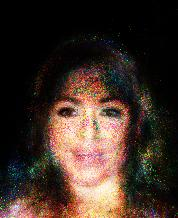

21600 [D loss: 0.293501, acc.: 89.06%] [G loss: 4.260978]


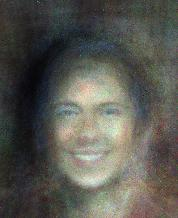

21800 [D loss: 0.510335, acc.: 89.06%] [G loss: 7.221859]


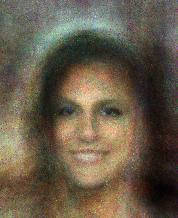

22000 [D loss: 0.170082, acc.: 95.31%] [G loss: 4.669802]


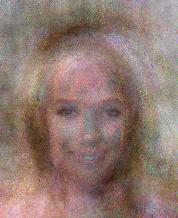

22200 [D loss: 0.326572, acc.: 92.19%] [G loss: 4.865115]


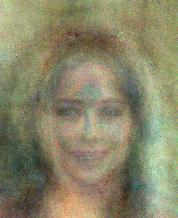

22400 [D loss: 0.232119, acc.: 87.50%] [G loss: 4.411883]


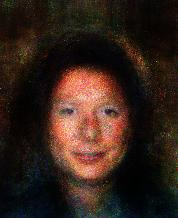

22600 [D loss: 0.279319, acc.: 87.50%] [G loss: 4.521943]


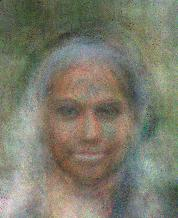

22800 [D loss: 0.132739, acc.: 96.88%] [G loss: 6.245582]


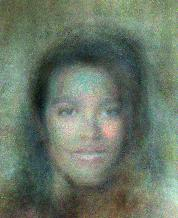

23000 [D loss: 0.280737, acc.: 87.50%] [G loss: 4.072339]


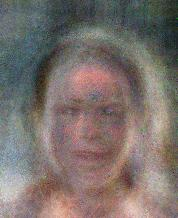

23200 [D loss: 0.183428, acc.: 92.19%] [G loss: 7.599789]


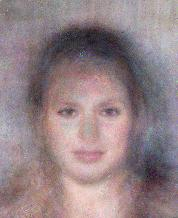

23400 [D loss: 0.402220, acc.: 87.50%] [G loss: 4.265837]


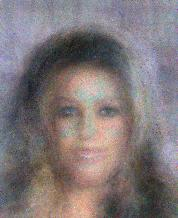

23600 [D loss: 0.158939, acc.: 95.31%] [G loss: 4.711097]


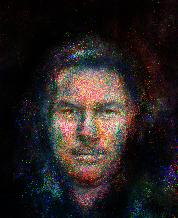

23800 [D loss: 0.072116, acc.: 95.31%] [G loss: 6.660883]


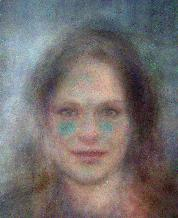

24000 [D loss: 0.353247, acc.: 85.94%] [G loss: 9.569168]


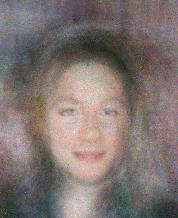

24200 [D loss: 0.121807, acc.: 93.75%] [G loss: 5.316333]


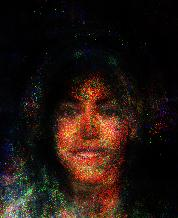

24400 [D loss: 0.225772, acc.: 93.75%] [G loss: 3.558794]


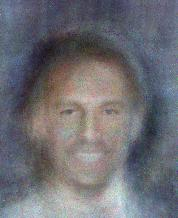

24600 [D loss: 0.618371, acc.: 71.88%] [G loss: 4.106184]


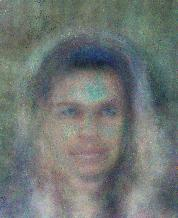

24800 [D loss: 0.265242, acc.: 89.06%] [G loss: 5.242308]


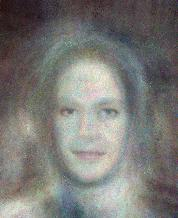

25000 [D loss: 0.152863, acc.: 93.75%] [G loss: 13.775083]


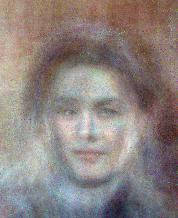

25200 [D loss: 0.167183, acc.: 96.88%] [G loss: 3.154676]


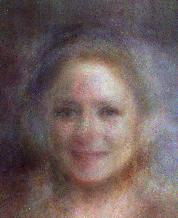

25400 [D loss: 0.175561, acc.: 96.88%] [G loss: 11.208786]


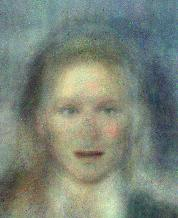

25600 [D loss: 0.260919, acc.: 90.62%] [G loss: 7.510485]


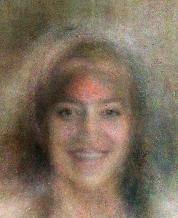

25800 [D loss: 0.223153, acc.: 92.19%] [G loss: 3.187828]


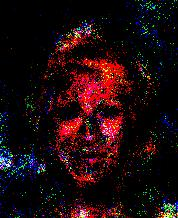

26000 [D loss: 0.269640, acc.: 87.50%] [G loss: 4.762168]


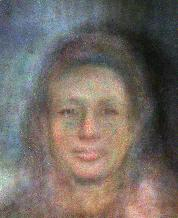

26200 [D loss: 0.078587, acc.: 95.31%] [G loss: 11.034067]


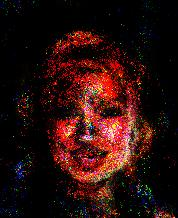

26400 [D loss: 0.233587, acc.: 92.19%] [G loss: 4.130484]


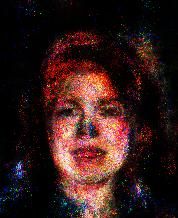

26600 [D loss: 0.217473, acc.: 93.75%] [G loss: 9.144819]


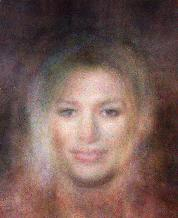

26800 [D loss: 0.125128, acc.: 95.31%] [G loss: 5.799149]


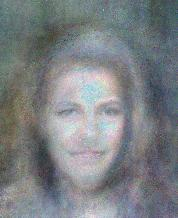

27000 [D loss: 0.420184, acc.: 84.38%] [G loss: 4.679152]


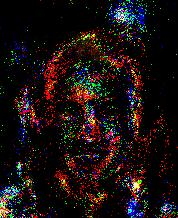

27200 [D loss: 0.159157, acc.: 92.19%] [G loss: 4.735839]


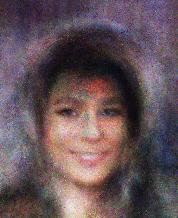

27400 [D loss: 0.137960, acc.: 95.31%] [G loss: 5.701424]


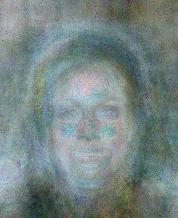

27600 [D loss: 0.159973, acc.: 93.75%] [G loss: 4.117435]


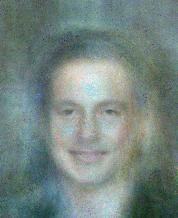

27800 [D loss: 0.086857, acc.: 96.88%] [G loss: 4.824383]


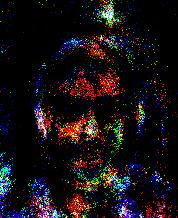

28000 [D loss: 0.236010, acc.: 92.19%] [G loss: 5.180153]


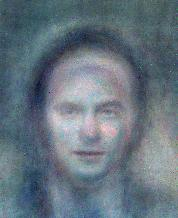

28200 [D loss: 0.109342, acc.: 95.31%] [G loss: 3.574582]


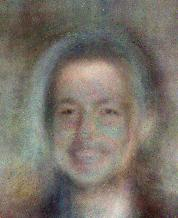

28400 [D loss: 0.111050, acc.: 95.31%] [G loss: 10.263535]


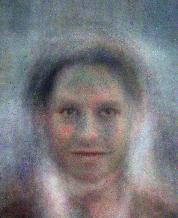

28600 [D loss: 0.110914, acc.: 96.88%] [G loss: 5.366231]


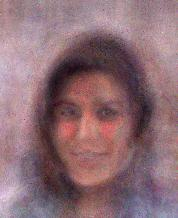

28800 [D loss: 0.087326, acc.: 98.44%] [G loss: 5.101194]


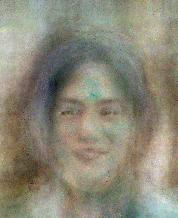

29000 [D loss: 0.064300, acc.: 96.88%] [G loss: 14.271474]


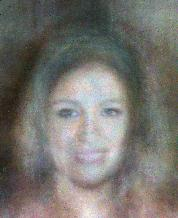

29200 [D loss: 0.391624, acc.: 82.81%] [G loss: 3.347582]


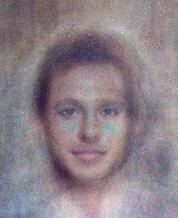

29400 [D loss: 0.173685, acc.: 89.06%] [G loss: 5.496873]


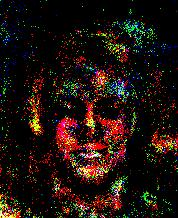

29600 [D loss: 0.085462, acc.: 98.44%] [G loss: 3.441240]


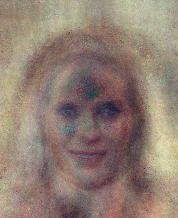

29800 [D loss: 0.077716, acc.: 98.44%] [G loss: 4.881590]


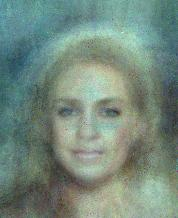

30000 [D loss: 0.305151, acc.: 90.62%] [G loss: 5.348277]


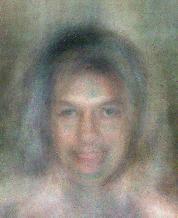

Saving weights...
...done.
30200 [D loss: 0.065465, acc.: 96.88%] [G loss: 7.170995]


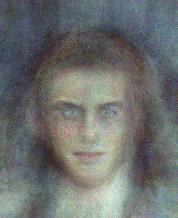

30400 [D loss: 0.178059, acc.: 92.19%] [G loss: 4.043082]


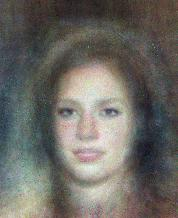

30600 [D loss: 0.161524, acc.: 93.75%] [G loss: 4.946448]


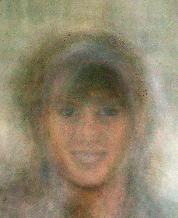

30800 [D loss: 0.111062, acc.: 96.88%] [G loss: 2.173879]


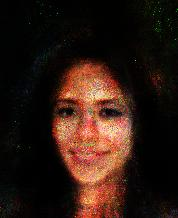

31000 [D loss: 0.127609, acc.: 95.31%] [G loss: 3.648517]


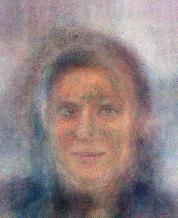

31200 [D loss: 0.065755, acc.: 98.44%] [G loss: 3.847864]


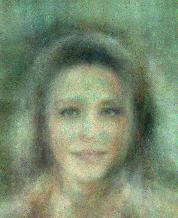

31400 [D loss: 0.425445, acc.: 90.62%] [G loss: 3.801126]


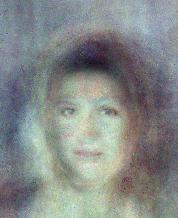

31600 [D loss: 0.248783, acc.: 90.62%] [G loss: 4.086626]


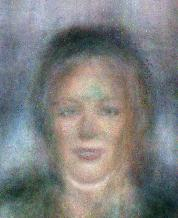

31800 [D loss: 0.198762, acc.: 90.62%] [G loss: 5.109309]


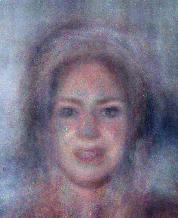

32000 [D loss: 0.250017, acc.: 87.50%] [G loss: 4.623226]


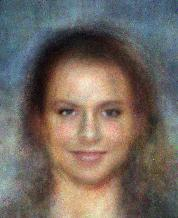

32200 [D loss: 0.029940, acc.: 100.00%] [G loss: 5.504582]


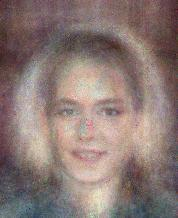

32400 [D loss: 0.175407, acc.: 92.19%] [G loss: 4.590855]


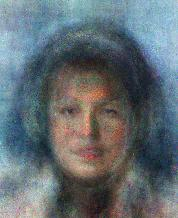

32600 [D loss: 0.219004, acc.: 89.06%] [G loss: 4.489745]


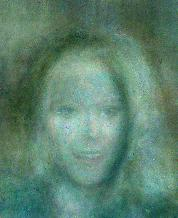

32800 [D loss: 0.108531, acc.: 95.31%] [G loss: 4.300452]


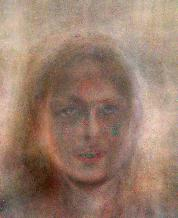

33000 [D loss: 0.067249, acc.: 96.88%] [G loss: 9.228284]


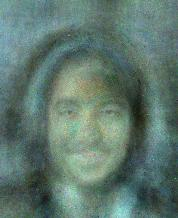

33200 [D loss: 0.209264, acc.: 93.75%] [G loss: 6.478842]


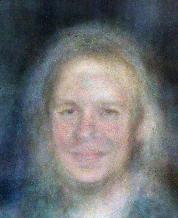

33400 [D loss: 0.093059, acc.: 96.88%] [G loss: 8.673124]


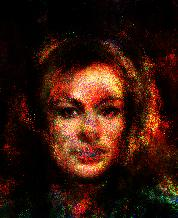

33600 [D loss: 0.401653, acc.: 82.81%] [G loss: 4.618159]


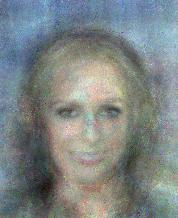

33800 [D loss: 0.162521, acc.: 93.75%] [G loss: 4.774695]


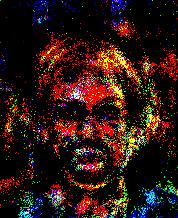

34000 [D loss: 0.201060, acc.: 89.06%] [G loss: 3.194731]


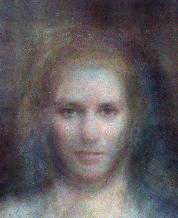

34200 [D loss: 0.181119, acc.: 93.75%] [G loss: 4.792823]


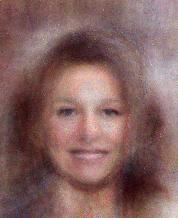

34400 [D loss: 0.036770, acc.: 100.00%] [G loss: 4.466799]


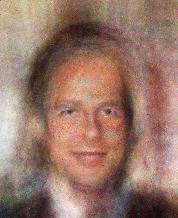

34600 [D loss: 0.204479, acc.: 92.19%] [G loss: 9.594309]


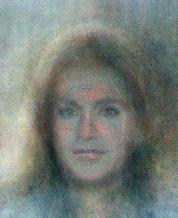

34800 [D loss: 0.129140, acc.: 96.88%] [G loss: 6.655509]


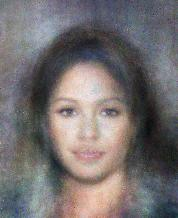

35000 [D loss: 0.130032, acc.: 95.31%] [G loss: 5.765296]


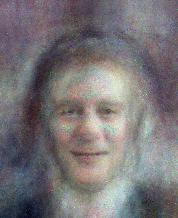

35200 [D loss: 0.089227, acc.: 96.88%] [G loss: 4.783340]


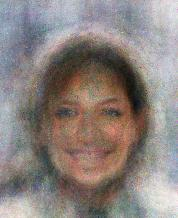

35400 [D loss: 0.108606, acc.: 96.88%] [G loss: 8.115168]


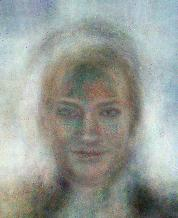

35600 [D loss: 0.209324, acc.: 90.62%] [G loss: 5.754338]


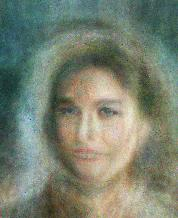

35800 [D loss: 0.336854, acc.: 87.50%] [G loss: 5.586648]


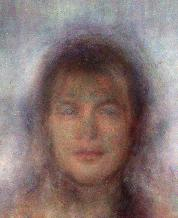

36000 [D loss: 0.110106, acc.: 98.44%] [G loss: 4.343285]


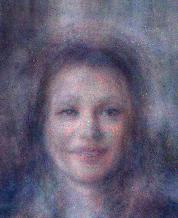

36200 [D loss: 0.273492, acc.: 84.38%] [G loss: 4.719229]


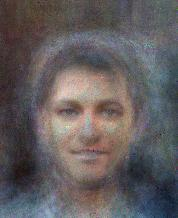

36400 [D loss: 0.101131, acc.: 95.31%] [G loss: 5.174532]


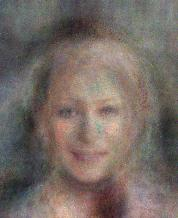

36600 [D loss: 0.270878, acc.: 87.50%] [G loss: 5.934283]


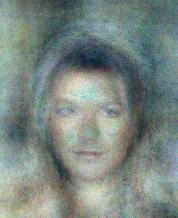

36800 [D loss: 0.062233, acc.: 98.44%] [G loss: 3.126802]


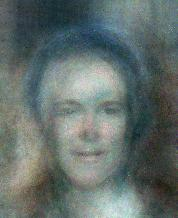

37000 [D loss: 0.154259, acc.: 93.75%] [G loss: 5.055285]


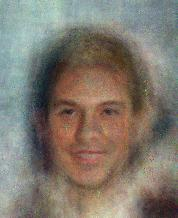

37200 [D loss: 0.050099, acc.: 100.00%] [G loss: 4.882490]


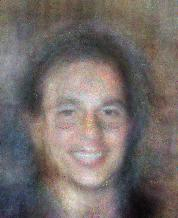

37400 [D loss: 0.218731, acc.: 93.75%] [G loss: 5.135036]


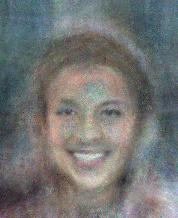

37600 [D loss: 0.105331, acc.: 100.00%] [G loss: 6.135649]


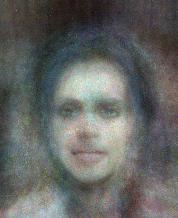

37800 [D loss: 0.167601, acc.: 90.62%] [G loss: 5.412547]


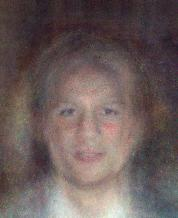

38000 [D loss: 0.188042, acc.: 93.75%] [G loss: 7.171584]


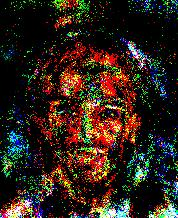

38200 [D loss: 0.151577, acc.: 93.75%] [G loss: 3.173928]


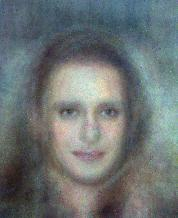

38400 [D loss: 0.175242, acc.: 95.31%] [G loss: 3.828916]


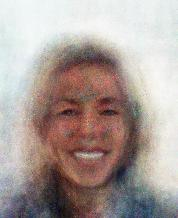

38600 [D loss: 0.088630, acc.: 95.31%] [G loss: 4.498896]


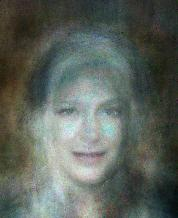

38800 [D loss: 0.247146, acc.: 90.62%] [G loss: 6.517247]


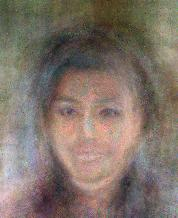

39000 [D loss: 0.133525, acc.: 90.62%] [G loss: 5.343466]


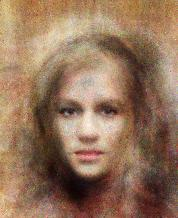

39200 [D loss: 0.065666, acc.: 98.44%] [G loss: 3.893240]


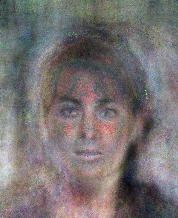

39400 [D loss: 0.149047, acc.: 93.75%] [G loss: 5.362477]


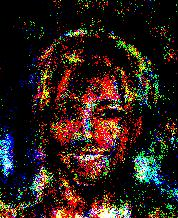

39600 [D loss: 0.233569, acc.: 89.06%] [G loss: 4.879039]


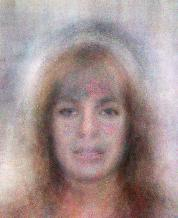

39800 [D loss: 0.069477, acc.: 98.44%] [G loss: 5.411887]


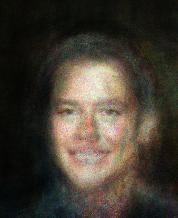

40000 [D loss: 0.171094, acc.: 93.75%] [G loss: 5.561750]


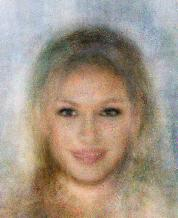

Saving weights...
...done.
40200 [D loss: 0.156639, acc.: 92.19%] [G loss: 6.750847]


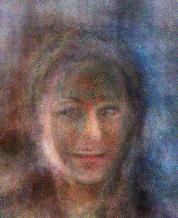

40400 [D loss: 0.117827, acc.: 96.88%] [G loss: 3.909629]


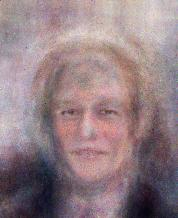

40600 [D loss: 0.095452, acc.: 95.31%] [G loss: 5.006729]


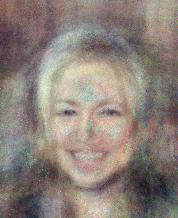

40800 [D loss: 0.277762, acc.: 92.19%] [G loss: 3.559229]


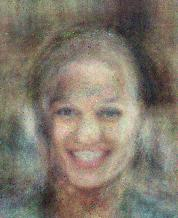

41000 [D loss: 0.163502, acc.: 95.31%] [G loss: 7.813954]


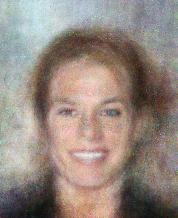

41200 [D loss: 0.234541, acc.: 92.19%] [G loss: 5.133746]


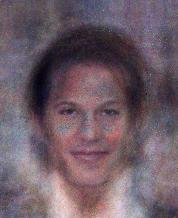

41400 [D loss: 0.126163, acc.: 93.75%] [G loss: 7.092827]


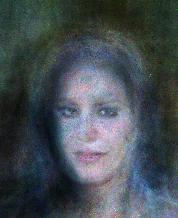

41600 [D loss: 0.069152, acc.: 98.44%] [G loss: 6.178302]


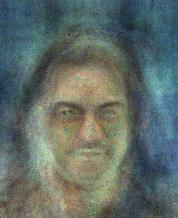

41800 [D loss: 0.183020, acc.: 92.19%] [G loss: 4.555978]


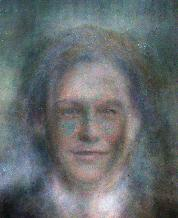

42000 [D loss: 0.162237, acc.: 90.62%] [G loss: 6.401809]


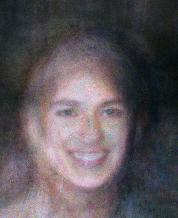

42200 [D loss: 0.280902, acc.: 89.06%] [G loss: 5.782016]


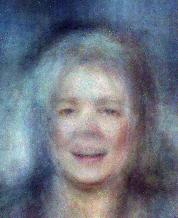

42400 [D loss: 0.554512, acc.: 82.81%] [G loss: 3.416384]


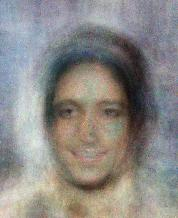

42600 [D loss: 0.278810, acc.: 87.50%] [G loss: 4.671703]


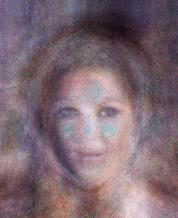

42800 [D loss: 0.044371, acc.: 98.44%] [G loss: 7.391354]


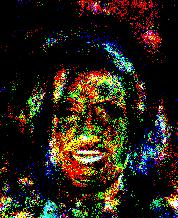

43000 [D loss: 0.174840, acc.: 95.31%] [G loss: 7.011231]


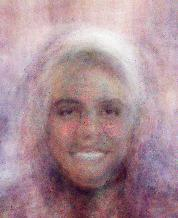

43200 [D loss: 0.235701, acc.: 89.06%] [G loss: 5.235809]


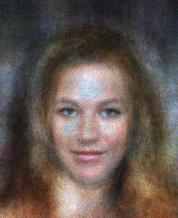

43400 [D loss: 0.178628, acc.: 93.75%] [G loss: 3.686452]


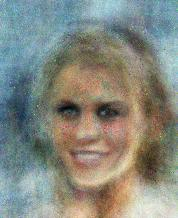

43600 [D loss: 0.097914, acc.: 96.88%] [G loss: 5.574734]


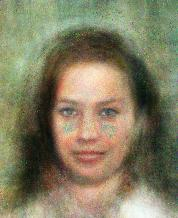

43800 [D loss: 0.140114, acc.: 95.31%] [G loss: 4.856625]


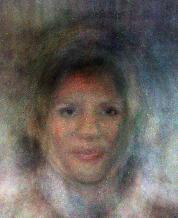

44000 [D loss: 0.040896, acc.: 96.88%] [G loss: 10.382366]


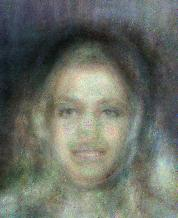

44200 [D loss: 0.196524, acc.: 90.62%] [G loss: 4.957798]


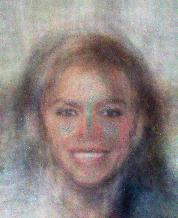

44400 [D loss: 0.051481, acc.: 98.44%] [G loss: 3.566507]


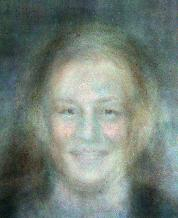

44600 [D loss: 0.087421, acc.: 96.88%] [G loss: 6.086614]


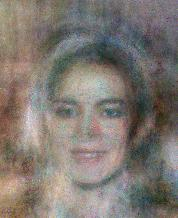

44800 [D loss: 0.053242, acc.: 98.44%] [G loss: 6.777445]


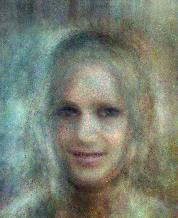

45000 [D loss: 0.035553, acc.: 98.44%] [G loss: 5.208132]


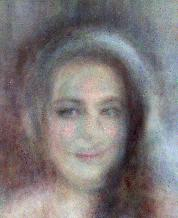

45200 [D loss: 0.168996, acc.: 92.19%] [G loss: 3.825896]


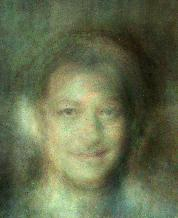

45400 [D loss: 0.206874, acc.: 90.62%] [G loss: 5.115283]


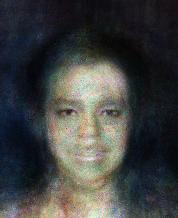

45600 [D loss: 0.130998, acc.: 93.75%] [G loss: 3.641955]


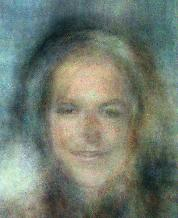

45800 [D loss: 0.818339, acc.: 75.00%] [G loss: 5.763144]


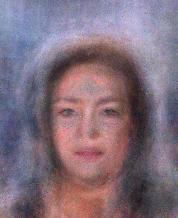

46000 [D loss: 0.123875, acc.: 93.75%] [G loss: 5.295922]


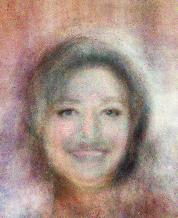

46200 [D loss: 0.209678, acc.: 89.06%] [G loss: 3.270573]


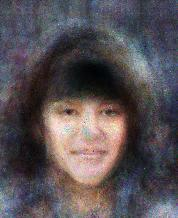

46400 [D loss: 0.317042, acc.: 92.19%] [G loss: 8.026738]


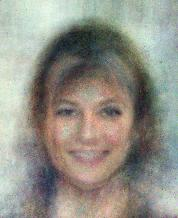

46600 [D loss: 0.100386, acc.: 95.31%] [G loss: 8.371276]


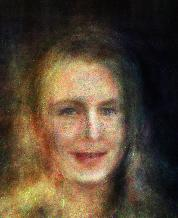

46800 [D loss: 0.063941, acc.: 98.44%] [G loss: 5.392975]


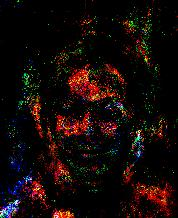

47000 [D loss: 0.135300, acc.: 95.31%] [G loss: 4.956839]


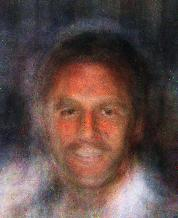

47200 [D loss: 0.061949, acc.: 98.44%] [G loss: 5.091276]


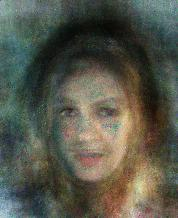

47400 [D loss: 0.171757, acc.: 89.06%] [G loss: 6.853864]


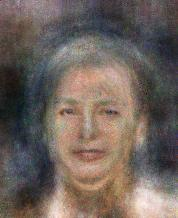

47600 [D loss: 0.095722, acc.: 95.31%] [G loss: 6.167227]


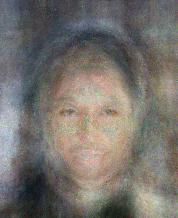

47800 [D loss: 0.096924, acc.: 95.31%] [G loss: 5.202517]


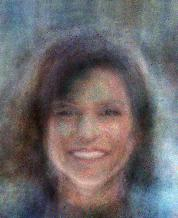

48000 [D loss: 0.061537, acc.: 98.44%] [G loss: 4.812329]


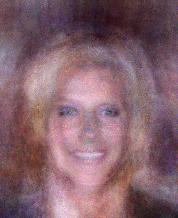

48200 [D loss: 0.159577, acc.: 93.75%] [G loss: 5.257106]


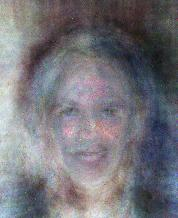

48400 [D loss: 0.082714, acc.: 96.88%] [G loss: 6.803881]


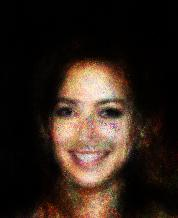

48600 [D loss: 0.168157, acc.: 89.06%] [G loss: 7.636125]


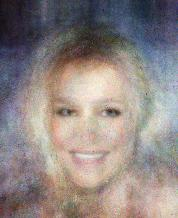

48800 [D loss: 0.268702, acc.: 93.75%] [G loss: 6.055761]


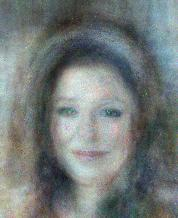

49000 [D loss: 0.161457, acc.: 95.31%] [G loss: 6.423615]


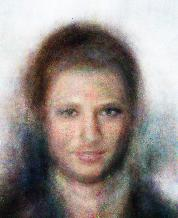

49200 [D loss: 0.091877, acc.: 96.88%] [G loss: 5.370430]


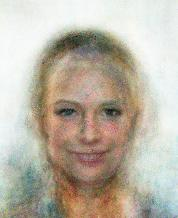

49400 [D loss: 0.148426, acc.: 95.31%] [G loss: 4.696999]


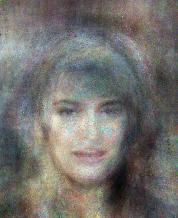

49600 [D loss: 0.119108, acc.: 93.75%] [G loss: 4.718086]


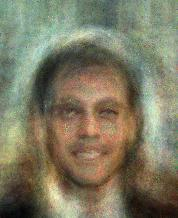

49800 [D loss: 0.163158, acc.: 93.75%] [G loss: 5.906018]


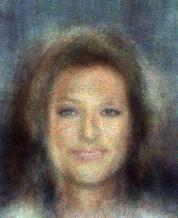

50000 [D loss: 0.148610, acc.: 95.31%] [G loss: 6.018973]


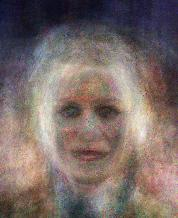

Saving weights...
...done.


In [7]:
for epoch in range(start_epoch, epochs +1): # +1 to get the final save

    # Train Discriminator

    # Sample a random batch of images
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]

    # Sample generator input
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    
    # Generate a batch of new images
    gen_imgs = generator.predict(noise)

    # Train
    d_loss_real = discriminator.train_on_batch(imgs, valid)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Sample generator input
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    
    # Train combined model
    g_loss = combined.train_on_batch(noise, valid)

    if epoch % info_interval == 0:
        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss)) 
        noise = np.random.normal(0, 1, (1, latent_dim))
        img = generator.predict(noise)
        show_image(img)
    
    if epoch % save_weights_interval == 0:
        print("Saving weights...")
        save_weights(generator, discriminator, epoch, '6-gans/weights')
        print("...done.")

## Samples from latent space

In [8]:
print('Generating...')
for n in range (100):
    noise = np.random.normal(0, 1, (1, latent_dim))
    img = generator.predict(noise)
    save_image_numbered(img, n, '6-gans/samples')
print('...done.')
montage_images('6-gans/samples', w, h)

Generating...
...done.
Montaging...
...done.


## Latent space interpolations

In [9]:
scenes = 50
seconds_per_scene = 6
frames_per_second = 25

frames = seconds_per_scene * frames_per_second
folder = '6-gans/frames/' + str(uuid.uuid4())
n = 0
ts = np.linspace(0.0, 1.0, num=frames)

previous = np.random.normal(0, 1, (1, latent_dim))
print('Generating...')
for s in range(scenes):
    new = np.random.normal(0, 1, (1, latent_dim))
    for t in ts:
        current = ((1-t) * previous) + (t * new)
        img = generator.predict(current)
        save_image_numbered(img, n, folder)
        n += 1
        # show_image(img)
    previous = new
print('...done.')
montage_images(folder, w, h)

Generating...
...done.
Montaging...
...done.


## GAN algorithm gallery

### DCGAN (2015)

Paper: [
Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks](https://arxiv.org/abs/1511.06434)

Original source: https://github.com/Newmu/dcgan_code

Keras implementation: https://github.com/eriklindernoren/Keras-GAN/tree/master/dcgan

### CycleGAN (2017)

Paper: [Unpaired Image-to-Image Translation
using Cycle-Consistent Adversarial Networks](https://arxiv.org/abs/1703.10593)

Original source: https://github.com/junyanz/CycleGAN

Keras implementation: https://github.com/eriklindernoren/Keras-GAN/tree/master/cyclegan

Video: https://www.youtube.com/watch?v=9reHvktowLY, https://www.youtube.com/watch?v=lCR9sT9mbis

### Pix2Pix (2017)

Paper: [
Image-to-Image Translation with Conditional Adversarial Networks](https://arxiv.org/abs/1611.07004)

Original source: https://github.com/phillipi/pix2pix

Keras implementation: https://github.com/eriklindernoren/Keras-GAN/tree/master/pix2pix

### Progressive Growing of GANs (2017)

Paper: [Progressive Growing of GANs for Improved Quality, Stability, and Variation](http://research.nvidia.com/publication/2017-10_Progressive-Growing-of)

Original Source: https://github.com/tkarras/progressive_growing_of_gans

Video: https://www.youtube.com/watch?v=G06dEcZ-QT

### More

https://github.com/eriklindernoren/Keras-GAN

https://github.com/zhangqianhui/AdversarialNetsPapers

## GAN art gallery

### Mario Klingenmann

http://quasimondo.com/

https://twitter.com/quasimondo

### Robbie Barrat

https://github.com/robbiebarrat

https://twitter.com/DrBeef_

### David Ha

http://blog.otoro.net/

https://twitter.com/hardmaru

### Mike Tyka

https://mtyka.github.io/

https://twitter.com/mtyka

### Fabian Offert

https://zentralwerkstatt.org/project_anthroposcene.html

https://vimeo.com/261611869

https://vimeo.com/235286541

https://zentralwerkstatt.org/files/4004.jpg

http://codingdurer.de/

### More

https://superrare.co/about